In [1]:
from cpselect.cpselect import cpselect
import json
from scipy.spatial import Delaunay
import skimage.io as skio
import skimage as sk
import numpy.linalg as linalg
import numpy as np
import imageio
import os
from scipy.interpolate import RectBivariateSpline
import multiprocessing
import functools
import matplotlib.pyplot as plt

In [2]:
# controlpointlist = cpselect("anish_portrait.jpg", "messi_portrait.jpg")
# Reading in image of Anish
# name of the input file
imname = 'anish_portrait.jpg'

im_anish = skio.imread(imname)
im_anish = sk.img_as_float(im_anish)

In [3]:
# Reading in image of Anish
# name of the input file
imname = 'messi_portrait.jpg'

im_messi = skio.imread(imname)
im_messi = sk.img_as_float(im_messi)

In [5]:
with open('anish_messi_control_pts.json') as jsonfile:
    control_pts = json.load(jsonfile)

In [3]:
# print(controlpointlist)

[{'point_id': 1, 'img1_x': 6.631014512856964, 'img1_y': 3.1966113548223802, 'img2_x': 8.102852865870318, 'img2_y': 5.536238794583369}, {'point_id': 2, 'img1_x': 977.5764020136518, 'img1_y': 3.1966113548223802, 'img2_x': 976.7086129269046, 'img2_y': 3.1966113548223802}, {'point_id': 3, 'img1_x': 8.97064195261791, 'img1_y': 1460.7845063258949, 'img2_x': 5.763225426109329, 'img2_y': 1465.4637612054166}, {'point_id': 4, 'img1_x': 970.5575196943689, 'img1_y': 1460.7845063258949, 'img2_x': 976.7086129269046, 'img2_y': 1465.4637612054166}, {'point_id': 5, 'img1_x': 390.329914633653, 'img1_y': 712.1037256023906, 'img2_x': 431.57541946260267, 'img2_y': 454.7447072286859}, {'point_id': 6, 'img1_x': 537.726443338593, 'img1_y': 721.4622353614344, 'img2_x': 595.3493402458694, 'img2_y': 473.4617267467736}, {'point_id': 7, 'img1_x': 324.82034632034635, 'img1_y': 693.386706084303, 'img2_x': 354.3677139504914, 'img2_y': 433.68806027083747}, {'point_id': 8, 'img1_x': 458.1791103867206, 'img1_y': 658.292

In [6]:
def avg_pts_calc(control_pts, sigma):
    avg_pts = np.array([[(i['img1_x']*sigma+i['img2_x']*(1-sigma)), (i['img1_y']*sigma+i['img2_y']*(1-sigma))] for i in control_pts])
    anish_pts = np.array([[i['img1_x'], i['img1_y']] for i in control_pts])
    messi_pts = np.array([[i['img2_x'], i['img2_y']] for i in control_pts])
    return avg_pts, anish_pts, messi_pts

avg_pts, anish_pts, messi_pts = avg_pts_calc(control_pts, 0.5)

In [7]:
def just_avg_pts_calc(lst_pts, width, height):
    print(width, height)
    avg_pts = lst_pts[0]
    for i in range(1, len(lst_pts)):
        avg_pts = np.add(avg_pts, lst_pts[i])
    avg_pts = np.array([[i[0]*width, i[1]*height] for i in avg_pts])
    return avg_pts/len(lst_pts)
    

In [8]:
avg_triangulation = Delaunay(avg_pts)
anish_triangulation = Delaunay(anish_pts)
messi_triangulation = Delaunay(messi_pts)

In [69]:
print(anish_pts[0].dtype)

float64


In [11]:
anish_triangles = anish_pts[avg_triangulation.simplices]
messi_triangles = messi_pts[avg_triangulation.simplices]
avg_triangles = avg_pts[avg_triangulation.simplices]


In [9]:
def affine_transformation(og_tri, avg_tri):
    tmp1 = np.matrix([og_tri[:,0], og_tri[:,1], [1,1,1]])
    tmp2 = np.matrix([avg_tri[:,0], avg_tri[:,1], [1,1,1]])
    return tmp2 * linalg.inv(tmp1)

In [10]:
def gen_spline(im, cc, rr, tmp_mask):
    return_mask = np.zeros_like(im)
    for i in range(len(im[0][0])):
        spline = RectBivariateSpline(range(im.shape[0]), range(im.shape[1]), im[:,:,i])
        return_mask[tmp_mask[1], tmp_mask[0], i] = spline(rr, cc, grid=False)
    return return_mask
        

In [11]:
def gen_mask(avg_tri, shape, affine_mat, im):
    #almost def wrong
    if shape:
        points = sk.draw.polygon(avg_tri[:,0], avg_tri[:,1], shape=shape)
    else:
        points = sk.draw.polygon(avg_tri[:,0], avg_tri[:,1])  
    tmp_mask = np.vstack([points[0], points[1], np.ones(len(points[0]))])
    tmp_mask = tmp_mask.astype(np.int)
    cc, rr, _ = linalg.inv(affine_mat)*tmp_mask
#     cc = cc.astype(np.int)
#     rr = rr.astype(np.int)
    return_mask = gen_spline(im, cc, rr, tmp_mask)
    return return_mask

In [12]:
def midway_gen(im1, im2, avg_triangles, im1_triangles, im2_triangles, sigma):
    midway = np.zeros_like(im1)
    for index in range(len(avg_triangles)):
        avg_t = avg_triangles[index]
        mask_shape = (im1.shape[1], im1.shape[0], im1.shape[2])

        anish_t = im1_triangles[index]    
        affine_mat = affine_transformation(anish_t, avg_t)
        inverse_warp = sigma*gen_mask(avg_t, mask_shape, affine_mat, im1)

        messi_t = im2_triangles[index]    
        affine_mat = affine_transformation(messi_t, avg_t)
        inverse_warp += (1-sigma)*gen_mask(avg_t, mask_shape, affine_mat, im2)

        midway += inverse_warp
    return midway

In [94]:
# Midway face for anish and messi!
midway = midway_gen(im_anish, im_messi, avg_triangles, anish_triangles, messi_triangles, 0.5)
# midway = np.clip(midway, 0, 1)
skio.imshow(midway)
skio.show()
    
    

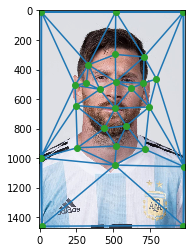

In [230]:

plt.triplot(messi_pts[:,0], messi_pts[:,1], avg_triangulation.simplices.copy())
plt.plot(messi_pts[:,0], messi_pts[:,1], 'o')
plt.imshow(im_messi)


In [82]:
fname = 'anish_messi_midway_test.jpg'
skio.imsave(fname, midway)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [13]:
def morph_helper(im1, im2, control_pts, frames, final, sigma):
    temp_avg, im1_pts, im2_pts = avg_pts_calc(control_pts, sigma/frames)
    avg_triangulation = Delaunay(temp_avg)
    im1_triangles = im1_pts[avg_triangulation.simplices]
    im2_triangles = im2_pts[avg_triangulation.simplices]
    avg_triangles = temp_avg[avg_triangulation.simplices]

    final[sigma-1] = midway_gen(im1, im2, avg_triangles, im1_triangles, im2_triangles, sigma/frames)
    print(sigma)

In [14]:
def morph_multi(im1, im2, control_pts, frames):
    final = [0]*frames
    pool = multiprocessing.Pool(processes=frames)
    temp_helper = functools.partial(morph_helper, im1, im2, control_pts, frames, final=final)
    pool.map(temp_helper, range(1,frames+1))
    imageio.mimsave('anish_messi.gif', final)
    return None

In [15]:
def morph(im1, im2, control_pts, frames):
    print('got here')
    final = []
    for i in range(frames):
        temp_avg, im1_pts, im2_pts = avg_pts_calc(control_pts, i/frames)
        avg_triangulation = Delaunay(temp_avg)
        im1_triangles = im1_pts[avg_triangulation.simplices]
        im2_triangles = im2_pts[avg_triangulation.simplices]
        avg_triangles = temp_avg[avg_triangulation.simplices]
        
        final.append(midway_gen(im1, im2, avg_triangles, im1_triangles, im2_triangles, i/frames))
        print(i)
    return final
    

In [179]:
# Morphing Anish and Messi
morphed_anish_messi = morph(im_anish, im_messi, control_pts, 45)
imageio.mimsave('anish_messi.gif', morphed_anish_messi)

In [16]:
def read_population(path):
    images = []
    pts = []
    for file in os.listdir(path):
        if file.endswith(".jpg"):
            file = 'imm_face_db/' + file
            im = skio.imread(file)
            im = sk.img_as_float(im)
            images.append(im)
            asf_file_name = file.replace(".jpg", ".asf")
            tmp_pts = np.genfromtxt(asf_file_name, skip_header=10, skip_footer=1, usecols=(2,3))
            pts.append(tmp_pts)
    return images, pts
            

In [17]:
def morph_population(im1, im1_pts, avg_shape, frames):
    print('got here')
    final = []
    for i in range(frames):
        avg_triangulation = Delaunay(avg_shape)
        im1_triangles = im1_pts[avg_triangulation.simplices]
        avg_triangles = avg_shape[avg_triangulation.simplices]
        
        final.append(midway_gen(im1, im1, avg_triangles, im1_triangles, im1_triangles, i/frames))
    return final

In [18]:
def avg_pop_img(images, avg_shape, pop_pts):
    avg_triangulation = Delaunay(avg_shape)
    avg_triangles = avg_shape[avg_triangulation.simplices]
    result = np.zeros_like(images[0])
    sigma = 1/len(images)
    for index in range(0, min(25, len(avg_triangles))):
        avg_t = avg_triangles[index]
        mask_shape = (images[0].shape[1], images[0].shape[0], images[0].shape[2])
        
        temp_t = pop_pts[0][avg_triangulation.simplices][index]
        affine_mat = affine_transformation(temp_t, avg_t)
        inverse_warp = gen_mask(avg_t, mask_shape, affine_mat, images[0])
        
        for im_index in range(1, len(images)):
            temp_t = pop_pts[im_index][avg_triangulation.simplices][index]
            affine_mat = affine_transformation(temp_t, avg_t)
            inverse_warp += gen_mask(avg_t, mask_shape, affine_mat, images[im_index])

        result += inverse_warp
    return result/min(len(images), 25)

In [180]:
# Computing avg face shape
images, pop_pts = read_population('imm_face_db')


In [235]:
avg_shape = just_avg_pts_calc(pop_pts, len(images[0]), len(images[0][0]))


480 640


In [ ]:

avg_im = avg_pop_img(images, avg_shape, pop_pts)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


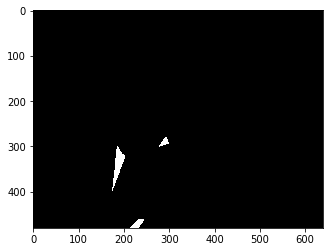

In [238]:
plt.imshow(avg_im)


In [77]:
im1_im1_morph = morph_population(images[0], pop_pts[0], avg_shape, 15)

got here


In [73]:
images[0].dtype

dtype('uint8')

In [156]:
# Bells & Whistles
# Changing gender
controlpointlist = cpselect("anish_portrait.jpg", "watson_portrait.jpg")


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.7/site-packages/cpselect/cpselect.py", line 327, in mouseClicked
    self.CPactive.appendCoord(x, y)
  File "/opt/anaconda3/lib/python3.7/site-packages/cpselect/cpselect.py", line 363, in appendCoord
    raise Exception("Please, select the control point in the other image")
Exception: Please, select the control point in the other image


In [164]:
with open('anish_watson_control_pts.json', 'w') as outfile:
    json.dump(controlpointlist, outfile)
control_pts = controlpointlist

In [158]:
# Reading in image of Emma Watson
# name of the input file
imname = 'watson_portrait.jpg'

im_watson = skio.imread(imname)
im_watson = sk.img_as_float(im_watson)

In [165]:
avg_pts, anish_pts, watson_pts = avg_pts_calc(control_pts, 0.5)

In [166]:
# Calculating triangles for Anish + Emma Watson
avg_triangulation = Delaunay(avg_pts)
anish_triangles = anish_pts[avg_triangulation.simplices]
watson_triangles = watson_pts[avg_triangulation.simplices]
avg_triangles = avg_pts[avg_triangulation.simplices]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


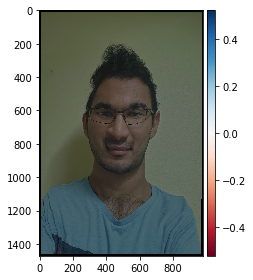

Lossy conversion from float64 to uint8. Range [-0.018663748935268287, 0.5231412763796651]. Convert image to uint8 prior to saving to suppress this warning.


In [169]:
midway = midway_gen(im_anish, im_watson, avg_triangles, anish_triangles, watson_triangles, 0.5)
skio.imshow(midway)
skio.show()
fname = 'anish_woman_midway_test.jpg'
skio.imsave(fname, midway)

In [ ]:
morphed_anish_watson = morph(im_anish, im_watson, control_pts, 45)
imageio.mimsave('anish_watson.gif', morphed_anish_watson)

In [22]:
# Bells & Whistles
# Morph between my different FB profile pics
controlpointlist = cpselect("anish_portrait.jpg", "V_mask.jpg")



In [23]:
with open('anish_profile_control_pts.json', 'w') as outfile:
    json.dump(controlpointlist, outfile)
control_pts = controlpointlist

In [24]:
# Reading in image of mask
# name of the input file
imname = 'V_mask.jpg'

im_V = skio.imread(imname)
im_V = sk.img_as_float(im_V)

In [26]:
avg_pts, anish_pts, V_pts = avg_pts_calc(control_pts, 0.5)
# Calculating triangles for Anish + V
avg_triangulation = Delaunay(avg_pts)
anish_triangles = anish_pts[avg_triangulation.simplices]
V_triangles = V_pts[avg_triangulation.simplices]
avg_triangles = avg_pts[avg_triangulation.simplices]

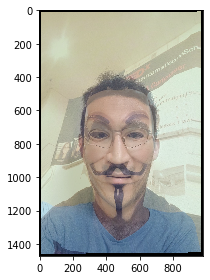

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [27]:
midway = midway_gen(im_anish, im_V, avg_triangles, anish_triangles, V_triangles, 0.5)
skio.imshow(midway)
skio.show()
fname = 'anish_V_midway_test.jpg'
skio.imsave(fname, midway)

In [28]:
morphed_anish_V = morph(im_anish, im_V, control_pts, 20)
imageio.mimsave('anish_V.gif', morphed_anish_V)

got here


Lossy conversion from float64 to uint8. Range [0.0, 1.0000000000000646]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1.0068014743434563]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conv

In [ ]:
controlpointlist = cpselect("joker_V.jpg", "anish_portrait.jpg")
with open('anish_V_profile_control_pts.json', 'w') as outfile:
    json.dump(controlpointlist, outfile)
control_pts = controlpointlist
# Reading in image of V profile pic
# name of the input file
imname = 'joker_V.jpg'

im_V = skio.imread(imname)
im_V = sk.img_as_float(im_V)
avg_pts, anish_pts, V_pts = avg_pts_calc(control_pts, 0.5)
# Calculating triangles for Anish + V
avg_triangulation = Delaunay(avg_pts)
anish_triangles = anish_pts[avg_triangulation.simplices]
V_triangles = V_pts[avg_triangulation.simplices]
avg_triangles = avg_pts[avg_triangulation.simplices]
morphed_anish_V_prof = morph(im_V, im_anish, control_pts, 15)
morphed_anish_V += morphed_anish_V_prof

got here
0
1
2
3
4
5
6
7
8


In [ ]:
imageio.mimsave('anish_V.gif', morphed_anish_V)